# Statistical Arbitrage Strategy Using Pairs Trading (XLE & VDE)

Imaara K.  
12/04/25
Implementing a statistical arbitrage strategy using cointegration-based pairs trading on two energy-sector ETFs: XLE and VDE. It uses Z-score thresholds to generate long/short signals and simulates the cumulative return from 2019–2025.

-Before running this notebook, install required packages with:
```bash
pip install yfinance statsmodels matplotlib

In [44]:
# === Import libraries ===
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Set start and end dates
start = "2019-01-01"
end = "2025-04-12"

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


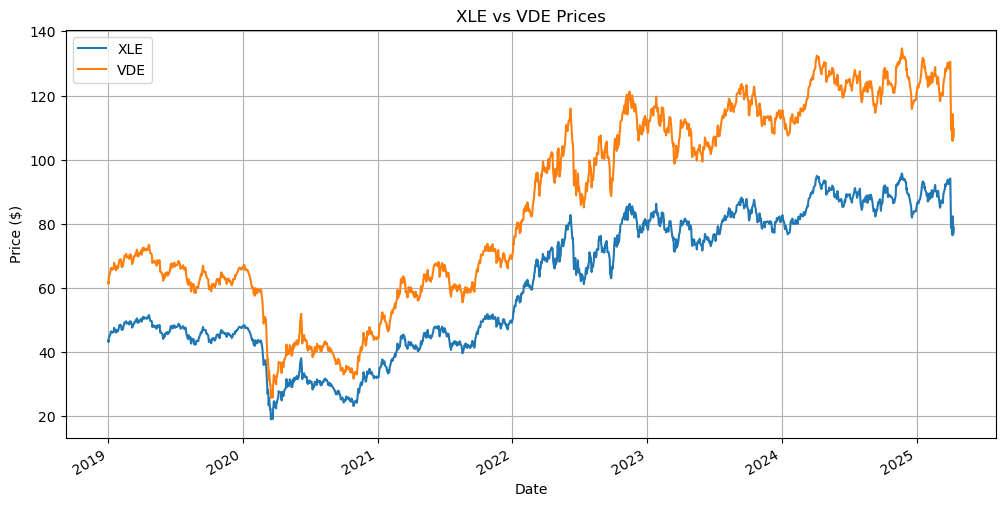

In [46]:
# === Download historical data for XLE and VDE ===
xle = yf.download("XLE", start=start, end=end)
vde = yf.download("VDE", start=start, end=end)

# Combine closing prices into a single DataFrame
data = pd.DataFrame()
data['XLE'] = xle['Close']
data['VDE'] = vde['Close']

# Plot XLE and VDE price series
data.plot(title="XLE vs VDE Prices", figsize=(12, 6))
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()

## Step 1: Test for Cointegration

We use the Engle-Granger test to determine if XLE and VDE have a statistically significant long-term relationship. A p-value less than 0.05 indicates cointegration, which is necessary for a pairs trading strategy.

In [48]:
from statsmodels.tsa.stattools import coint

score, pvalue, _ = coint(data['XLE'], data['VDE'])
print("Cointegration test p-value:", pvalue)

Cointegration test p-value: 0.04512318849280216


## Step 2: Calculate Hedge Ratio and Spread

We perform a linear regression of XLE on VDE to find the hedge ratio — this tells us how many units of VDE we need to hedge against XLE. We then calculate the spread (residuals), which we will monitor for trading signals.

Hedge ratio (XLE/VDE): 0.7084201874694278


/var/folders/lc/gn4d9txd0vd04qppj9kwr0nr0000gn/T/ipykernel_86005/715636724.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]


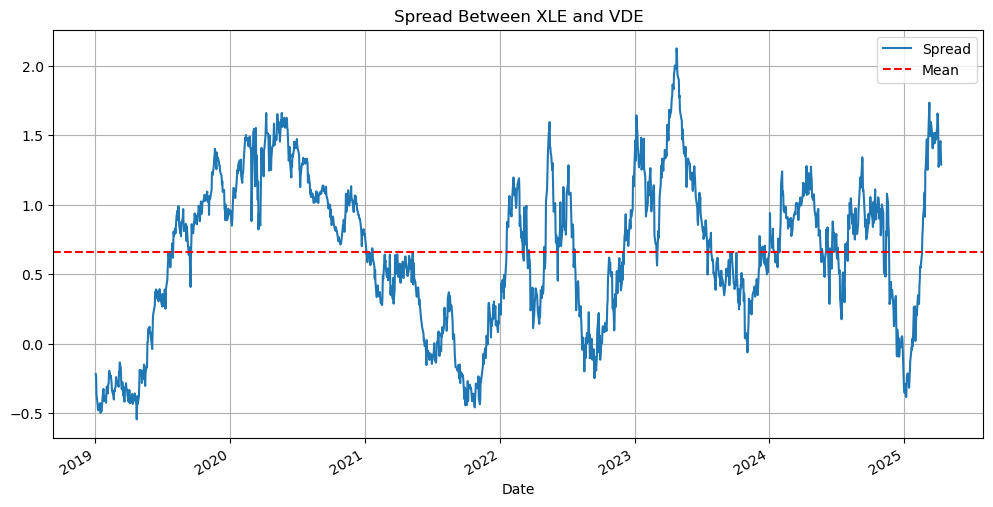

In [53]:
# Perform linear regression of XLE on VDE to calculate hedge ratio
X = sm.add_constant(data['VDE'])  # Add intercept
model = sm.OLS(data['XLE'], X).fit()
hedge_ratio = model.params[1]
print("Hedge ratio (XLE/VDE):", hedge_ratio)

# Calculate the spread (residual between XLE and hedge-adjusted VDE)
data['Spread'] = data['XLE'] - hedge_ratio * data['VDE']

# Plot the spread
data['Spread'].plot(title="Spread Between XLE and VDE", figsize=(12, 6))
plt.axhline(data['Spread'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.grid(True)
plt.show()

## Step 3: Generate Z-Score and Trading Signals

We calculate the Z-score of the spread to quantify how far it deviates from the mean. Based on this, we define trading signals:
- Go **long** when Z-score < -1 (buy XLE, sell VDE)
- Go **short** when Z-score > +1 (sell XLE, buy VDE)
- **Exit** when |Z-score| < 0.5 (mean reversion)

In [56]:
# Calculate Z-score of the spread
mean = data['Spread'].mean()
std = data['Spread'].std()
data['Z-Score'] = (data['Spread'] - mean) / std

# Define trading signals
data['Long'] = data['Z-Score'] < -1
data['Short'] = data['Z-Score'] > 1
data['Exit'] = abs(data['Z-Score']) < 0.5

# Preview the latest signals
data[['Z-Score', 'Long', 'Short', 'Exit']].tail()

,Z-Score,Long,Short,Exit
Date,,,,
2025-04-07,1.297385,False,True,False
2025-04-08,1.420593,False,True,False
2025-04-09,1.455119,False,True,False
2025-04-10,1.319793,False,True,False
2025-04-11,1.146207,False,True,False


## Step 4: Visualize Z-Score and Trade Entry Points

We visualize Z-score deviations and highlight when the strategy would have triggered long or short trades.

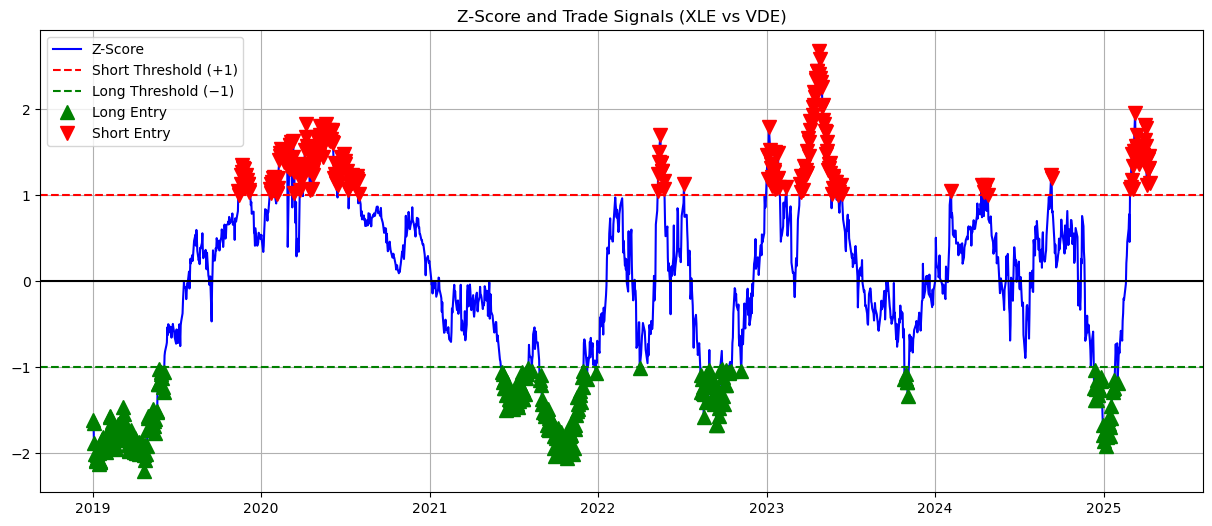

In [59]:
plt.figure(figsize=(15, 6))
plt.plot(data.index, data['Z-Score'], label='Z-Score', color='blue')
plt.axhline(1.0, color='red', linestyle='--', label='Short Threshold (+1)')
plt.axhline(-1.0, color='green', linestyle='--', label='Long Threshold (−1)')
plt.axhline(0.0, color='black', linestyle='-')

# Mark long and short entries
plt.plot(data[data['Long']].index, data['Z-Score'][data['Long']], '^', markersize=10, color='green', label='Long Entry')
plt.plot(data[data['Short']].index, data['Z-Score'][data['Short']], 'v', markersize=10, color='red', label='Short Entry')

plt.title("Z-Score and Trade Signals (XLE vs VDE)")
plt.legend()
plt.grid(True)
plt.show()

## Step 5: Backtest Strategy Performance

We simulate the strategy's performance by:
- Going **long XLE / short VDE** when the Z-score < −1
- Going **short XLE / long VDE** when the Z-score > +1
- Exiting the position when the Z-score returns toward 0

We calculate daily returns based on this logic and plot the cumulative performance over time.

In [62]:
# Calculate daily returns
data['XLE_ret'] = data['XLE'].pct_change()
data['VDE_ret'] = data['VDE'].pct_change()

# Initialize position column
data['Position'] = 0
data.loc[data['Long'], 'Position'] = 1
data.loc[data['Short'], 'Position'] = -1
data.loc[data['Exit'], 'Position'] = 0

# Forward-fill positions between entry and exit
data['Position'] = data['Position'].replace(0, pd.NA).ffill()

# Calculate daily strategy return
data['Strategy_Return'] = data['Position'] * (data['XLE_ret'] - hedge_ratio * data['VDE_ret'])

# Drop missing values
data = data.dropna(subset=['Strategy_Return'])

# Calculate cumulative return
data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()

/var/folders/lc/gn4d9txd0vd04qppj9kwr0nr0000gn/T/ipykernel_86005/4027858242.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Position'] = data['Position'].replace(0, pd.NA).ffill()
/var/folders/lc/gn4d9txd0vd04qppj9kwr0nr0000gn/T/ipykernel_86005/4027858242.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cumulative_Return'] = (1 + data['Strategy_Return']).cumprod()


Cumulative Return preview:
Date
2025-04-07    1.159857
2025-04-08    1.166621
2025-04-09    1.141297
2025-04-10    1.162822
2025-04-11    1.155817
Name: Cumulative_Return, dtype: float64


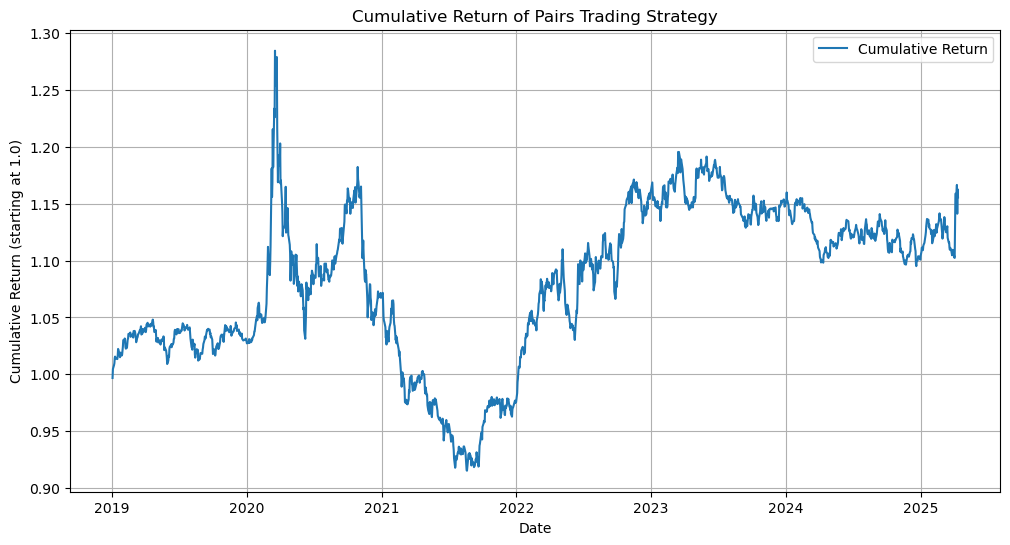

In [66]:
import matplotlib.pyplot as plt

# Check if we actually have values in Cumulative_Return
print("Cumulative Return preview:")
print(data['Cumulative_Return'].dropna().tail())

# Plot again explicitly
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Cumulative_Return'], label='Cumulative Return')
plt.title('Cumulative Return of Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (starting at 1.0)')
plt.grid(True)
plt.legend()
plt.show()